# Comparación de modelos



In [19]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [20]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
results_save_path = "../experimentos_split/results"


In [21]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300


Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Comparación

In [22]:
from importlib import reload
import utils.trainer
utils.trainer=reload(utils.trainer)

In [23]:
from importlib import reload
import utils.models
utils.models=reload(utils.models)

In [24]:
from utils import pygt_loader
import os
import torch
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions, plot_multiple_models

from utils.trainer import  TrainerAGCRN, TrainerDryGrEncoder, TrainerLSTMModel, TrainerMPNNLSTM, TrainerMSTGCN, TrainerDCRNN, TrainerMTGNN
from utils import trainer
dtype = torch.float
import ast
device = torch.device("mps")
import utils.models

In [25]:
problem = "gen_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/gen_trip


In [26]:
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)

n_div_gt = loader.div


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [27]:
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False}

### Varios modelos

In [28]:
def process_model(name, path_problem_results, dataset, dataloader_params_nobatch, problem):

    dataloader_params_nobatch['use_batch'] = False
    dataloader_params = dataloader_params_nobatch.copy()
    dataloader_params['use_batch'] = True


    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]
    device = torch.device("cpu")

    df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
    if name not in df['Modelo'].values:
        raise ValueError("Modelo no tiene resultados en el directorio de resultados")
    params_prelim = df[df['Modelo']==name]['Params'].values[0]
    try:
        params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
    except ValueError:
        params = {}

    print(params)
    if name =='DyGrEncoder':
        model= utils.models.DyGrEncoderModel("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=params['conv'], num_lstm=params['lstm'], aggr=params['aggr'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =='AGCRN':
        model = utils.models.AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=params['embedding'],hidden_size=params['hidden'],k=params['K'], n_target=n_target, name="AGCRN")
        print("path: ", os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params, verbose=False)

    #No hemos hecho ajuste de parámetros
    elif name =='LSTM':
        model = utils.models.LSTMModel(name="LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params, batch=True, verbose=False)
        
    elif name =='LSTM_NOBATCH':
        model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, batch=False, verbose=False)

    elif name == "MPNN_LSTM":
        model = utils.models.MPNNLSTMModel("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['hidden_size'], window=1, dropout=params['dropout'])
        print("path: ", os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMPNNLSTM(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name == "MSTGCN":
        model = utils.models.MSTGCNModel("MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'])
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt"), map_location=device))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name == "DCRNN":
        model = utils.models.DCRNNModel("DCRNN",node_features = n_features, node_count=n_nodes, n_target=n_target, hidden_dim=params["hidden"])
        print(os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="EvolveGCN":
        model = utils.models.EvolveGCNModel("EvolveGCN", node_features=n_features, node_count=n_nodes, n_target=n_target)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="ASTGCN":
        model = utils.models.ASTGCNModel("ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden_size = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'])
        print("path: ", os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =="MTGNN":
        model = utils.models.MTGNNModel(
                name="MTGNN", 
                node_count=n_nodes, 
                node_features=n_features, 
                n_target=n_target,
                conv_channels=params["conv_channels"],
                residual_channels=params["conv_channels"], 
                out_channels=params["out_channels"],
                skip_channels=params["conv_channels"] // 2, 
                end_channels=n_target, 
                gcn_depth=params["gcn_depth"],
                kernel_size=params["kernel_size"],
                dropout=params["dropout"],
                gcn_true=params["gcn_true"],
                build_adj=params["build_adj"],
                propalpha=params["propalpha"]
            )
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMTGNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    else:
        raise ValueError("Modelo no encontrado")
    return trainer


In [29]:
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features = dataset[0].x.shape[1]
device = torch.device("cpu")

name = "MPNN_LSTM"

df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
if name not in df['Modelo'].values:
    raise ValueError("Modelo no tiene resultados en el directorio de resultados")
params_prelim = df[df['Modelo']==name]['Params'].values[0]
try:
    params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
except ValueError:
    params = {}
params


{'hidden_size': 16, 'dropout': 0.2}

In [32]:

model = utils.models.MPNNLSTMModel("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['hidden_size'], window=1, dropout=params['dropout'])
print("path: ", os.path.join(path_problem_results, f"{name}.pt"))
model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt"), map_location=device))
model.to(device)
trainer = TrainerMPNNLSTM(model, dataset,device, f"./results/{problem}", dataloader_params, verbose=False)


path:  ../experimentos_split/results/gen_trip/MPNN_LSTM.pt


In [33]:
trainer.train(num_epochs=30)


==================== TRAIN INFO ===================



ValueError: Input contains NaN.

In [13]:
models_analysis = ["MPNN_LSTM"]
print("Problema: ", problem)
predictions = {}
real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
for model_name in models_analysis:
    print("\n\nModelo: ", model_name)
    trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
    _,_,_,preds, reals = trainer.test()
    predictions[model_name] = preds
    real[model_name] = reals


Problema:  gen_trip


Modelo:  MPNN_LSTM
{'hidden_size': 16, 'dropout': 0.2}
path:  ../experimentos_split/results/gen_trip/MPNN_LSTM.pt

==================== TEST INFO ===================



ValueError: Input contains NaN.

In [12]:
from importlib import reload

utils_graph =reload(utils.utils_graph)
from utils.utils_graph import plot_predictions, plot_multiple_models

In [13]:
path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"


[8, 9, 5, 7, 19, 15, 13, 4]


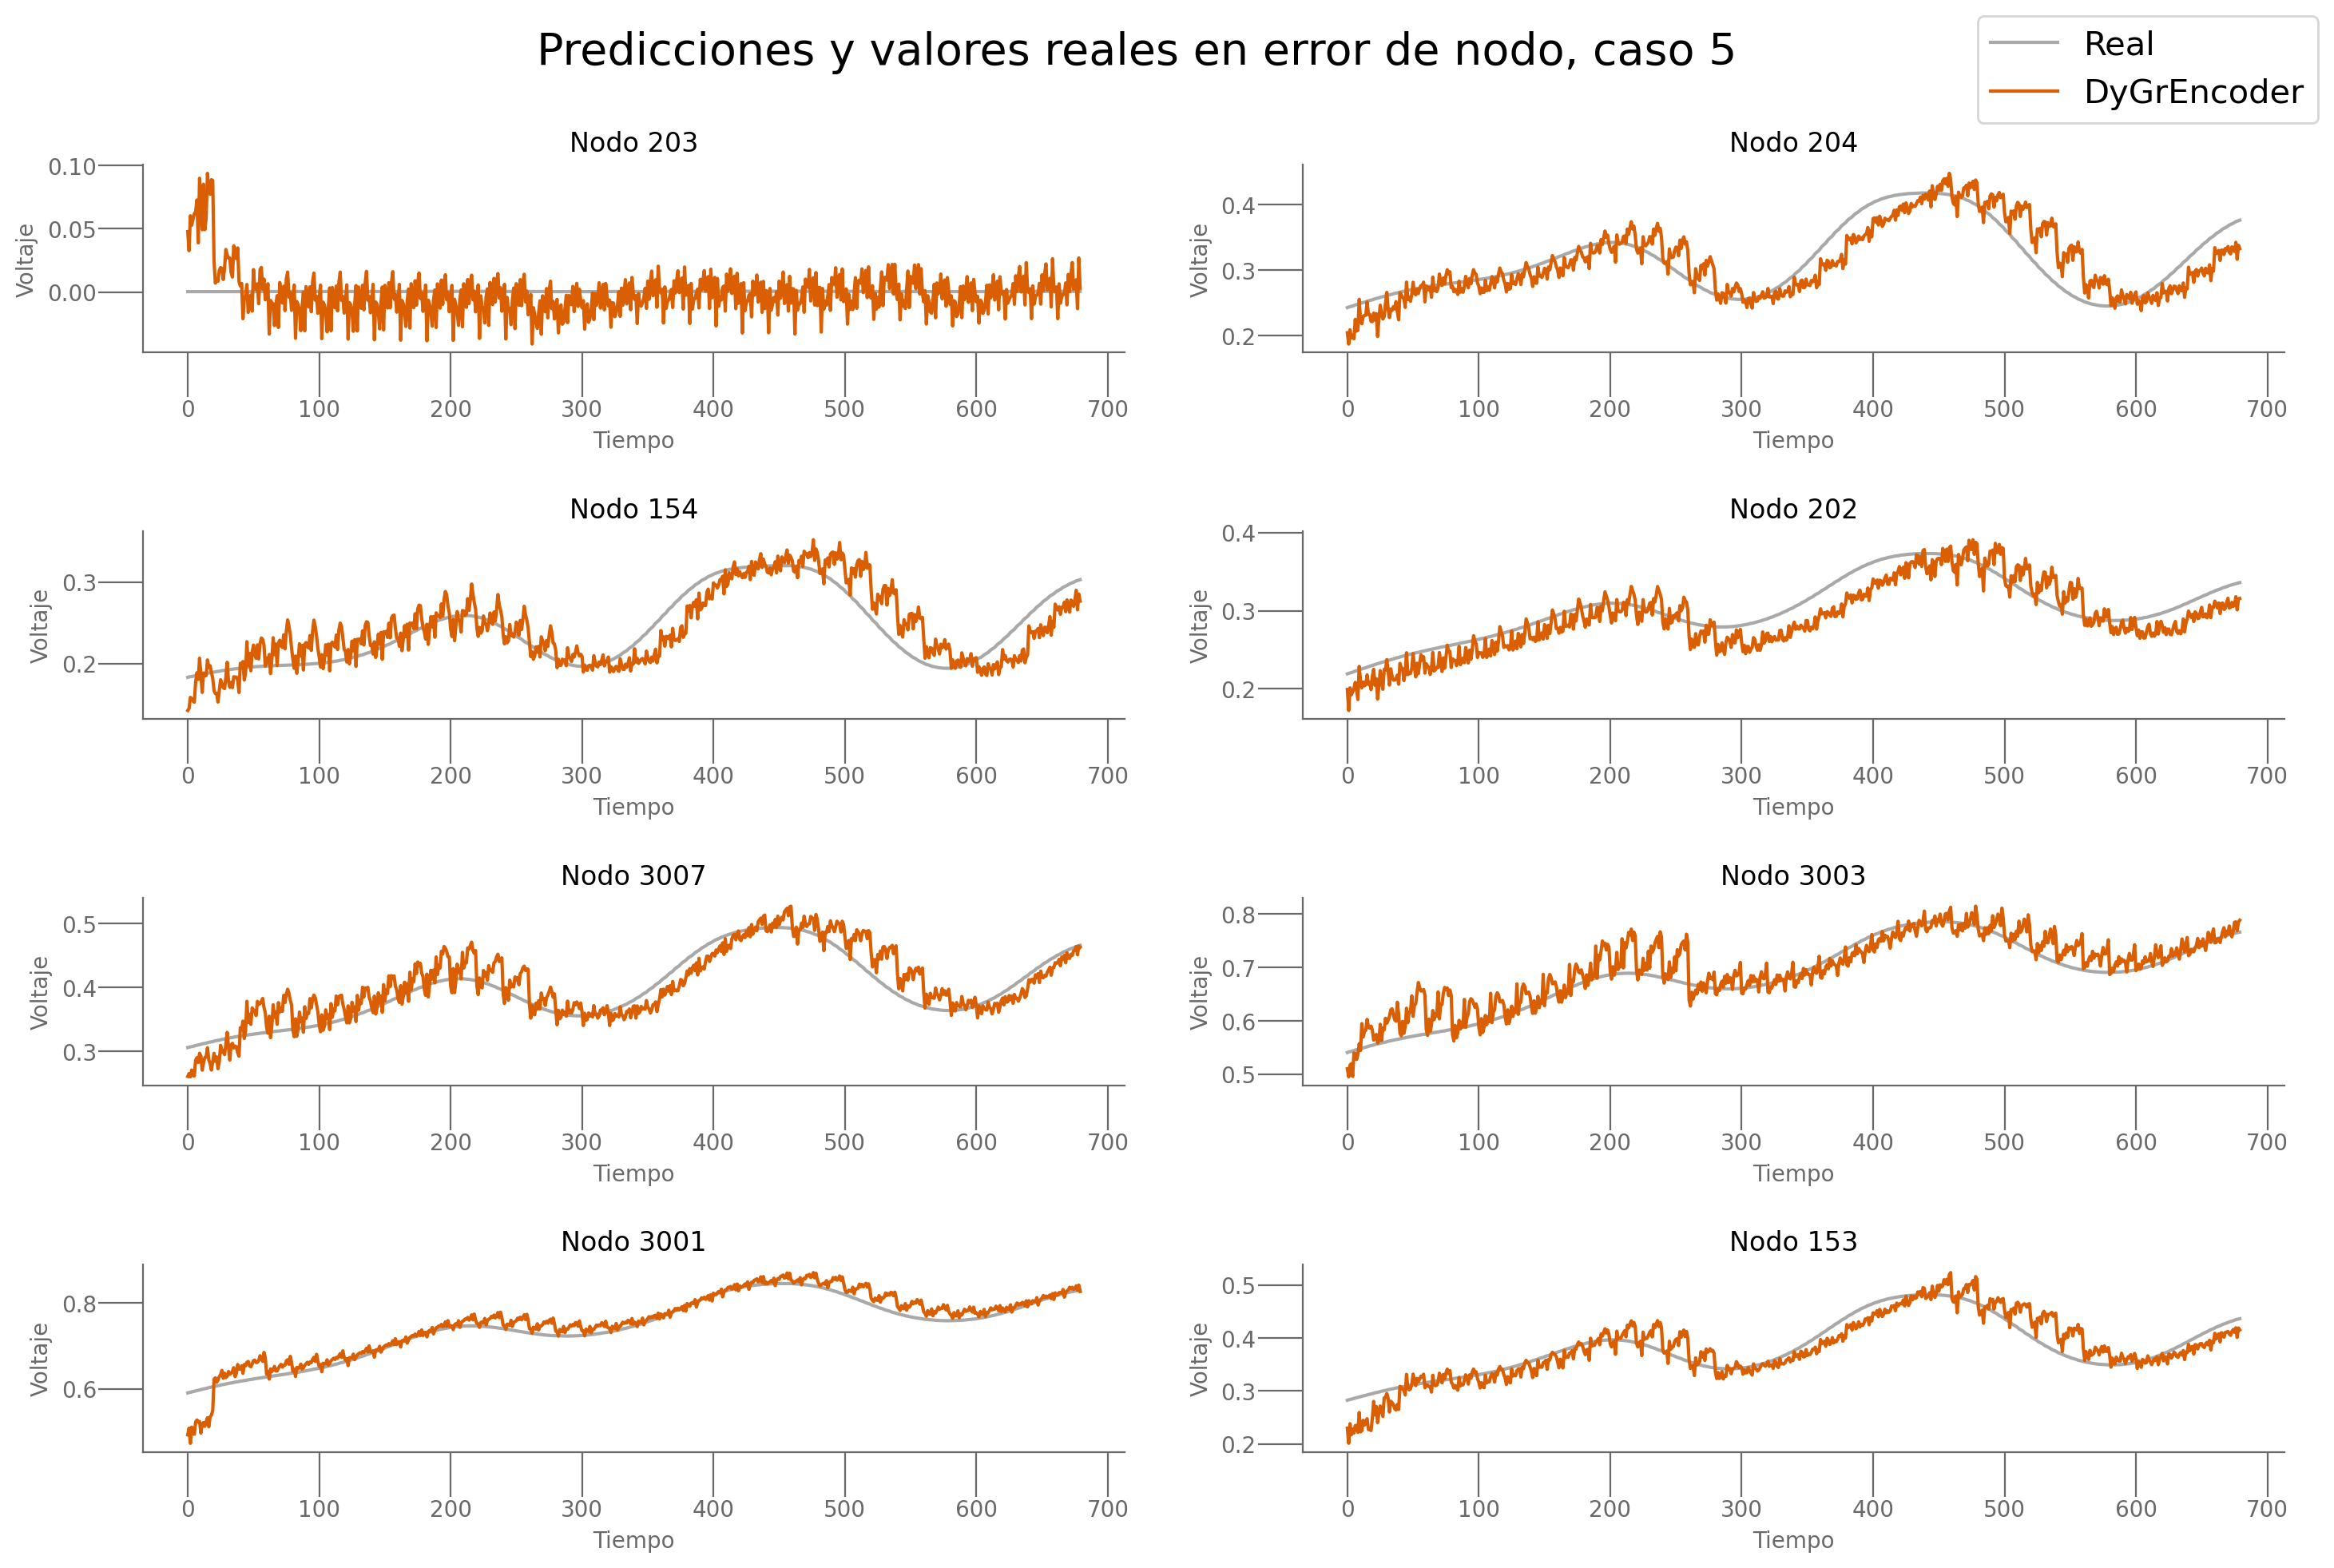

In [20]:
predictions_list= [value for value in predictions.values()]
real_list = [value for value in real.values()]
num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=5, n_div=n_div_gt, problem="error de nodo", names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
#plt.savefig()
plt.show()

Problema:  bus_fault
Procesando modelo:  DyGrEncoder


Modelo:  DyGrEncoder
{'aggr': 'mean', 'conv': 1, 'lstm': 1}

==================== TEST INFO ===================

test loss: 0.016905, test R2 score: -0.670304


Modelo:  LSTM_NOBATCH
{}

==================== TEST INFO ===================

test loss: 0.017863, test R2 score: -1.113234
[9, 10, 11, 5, 20, 17, 6, 16]


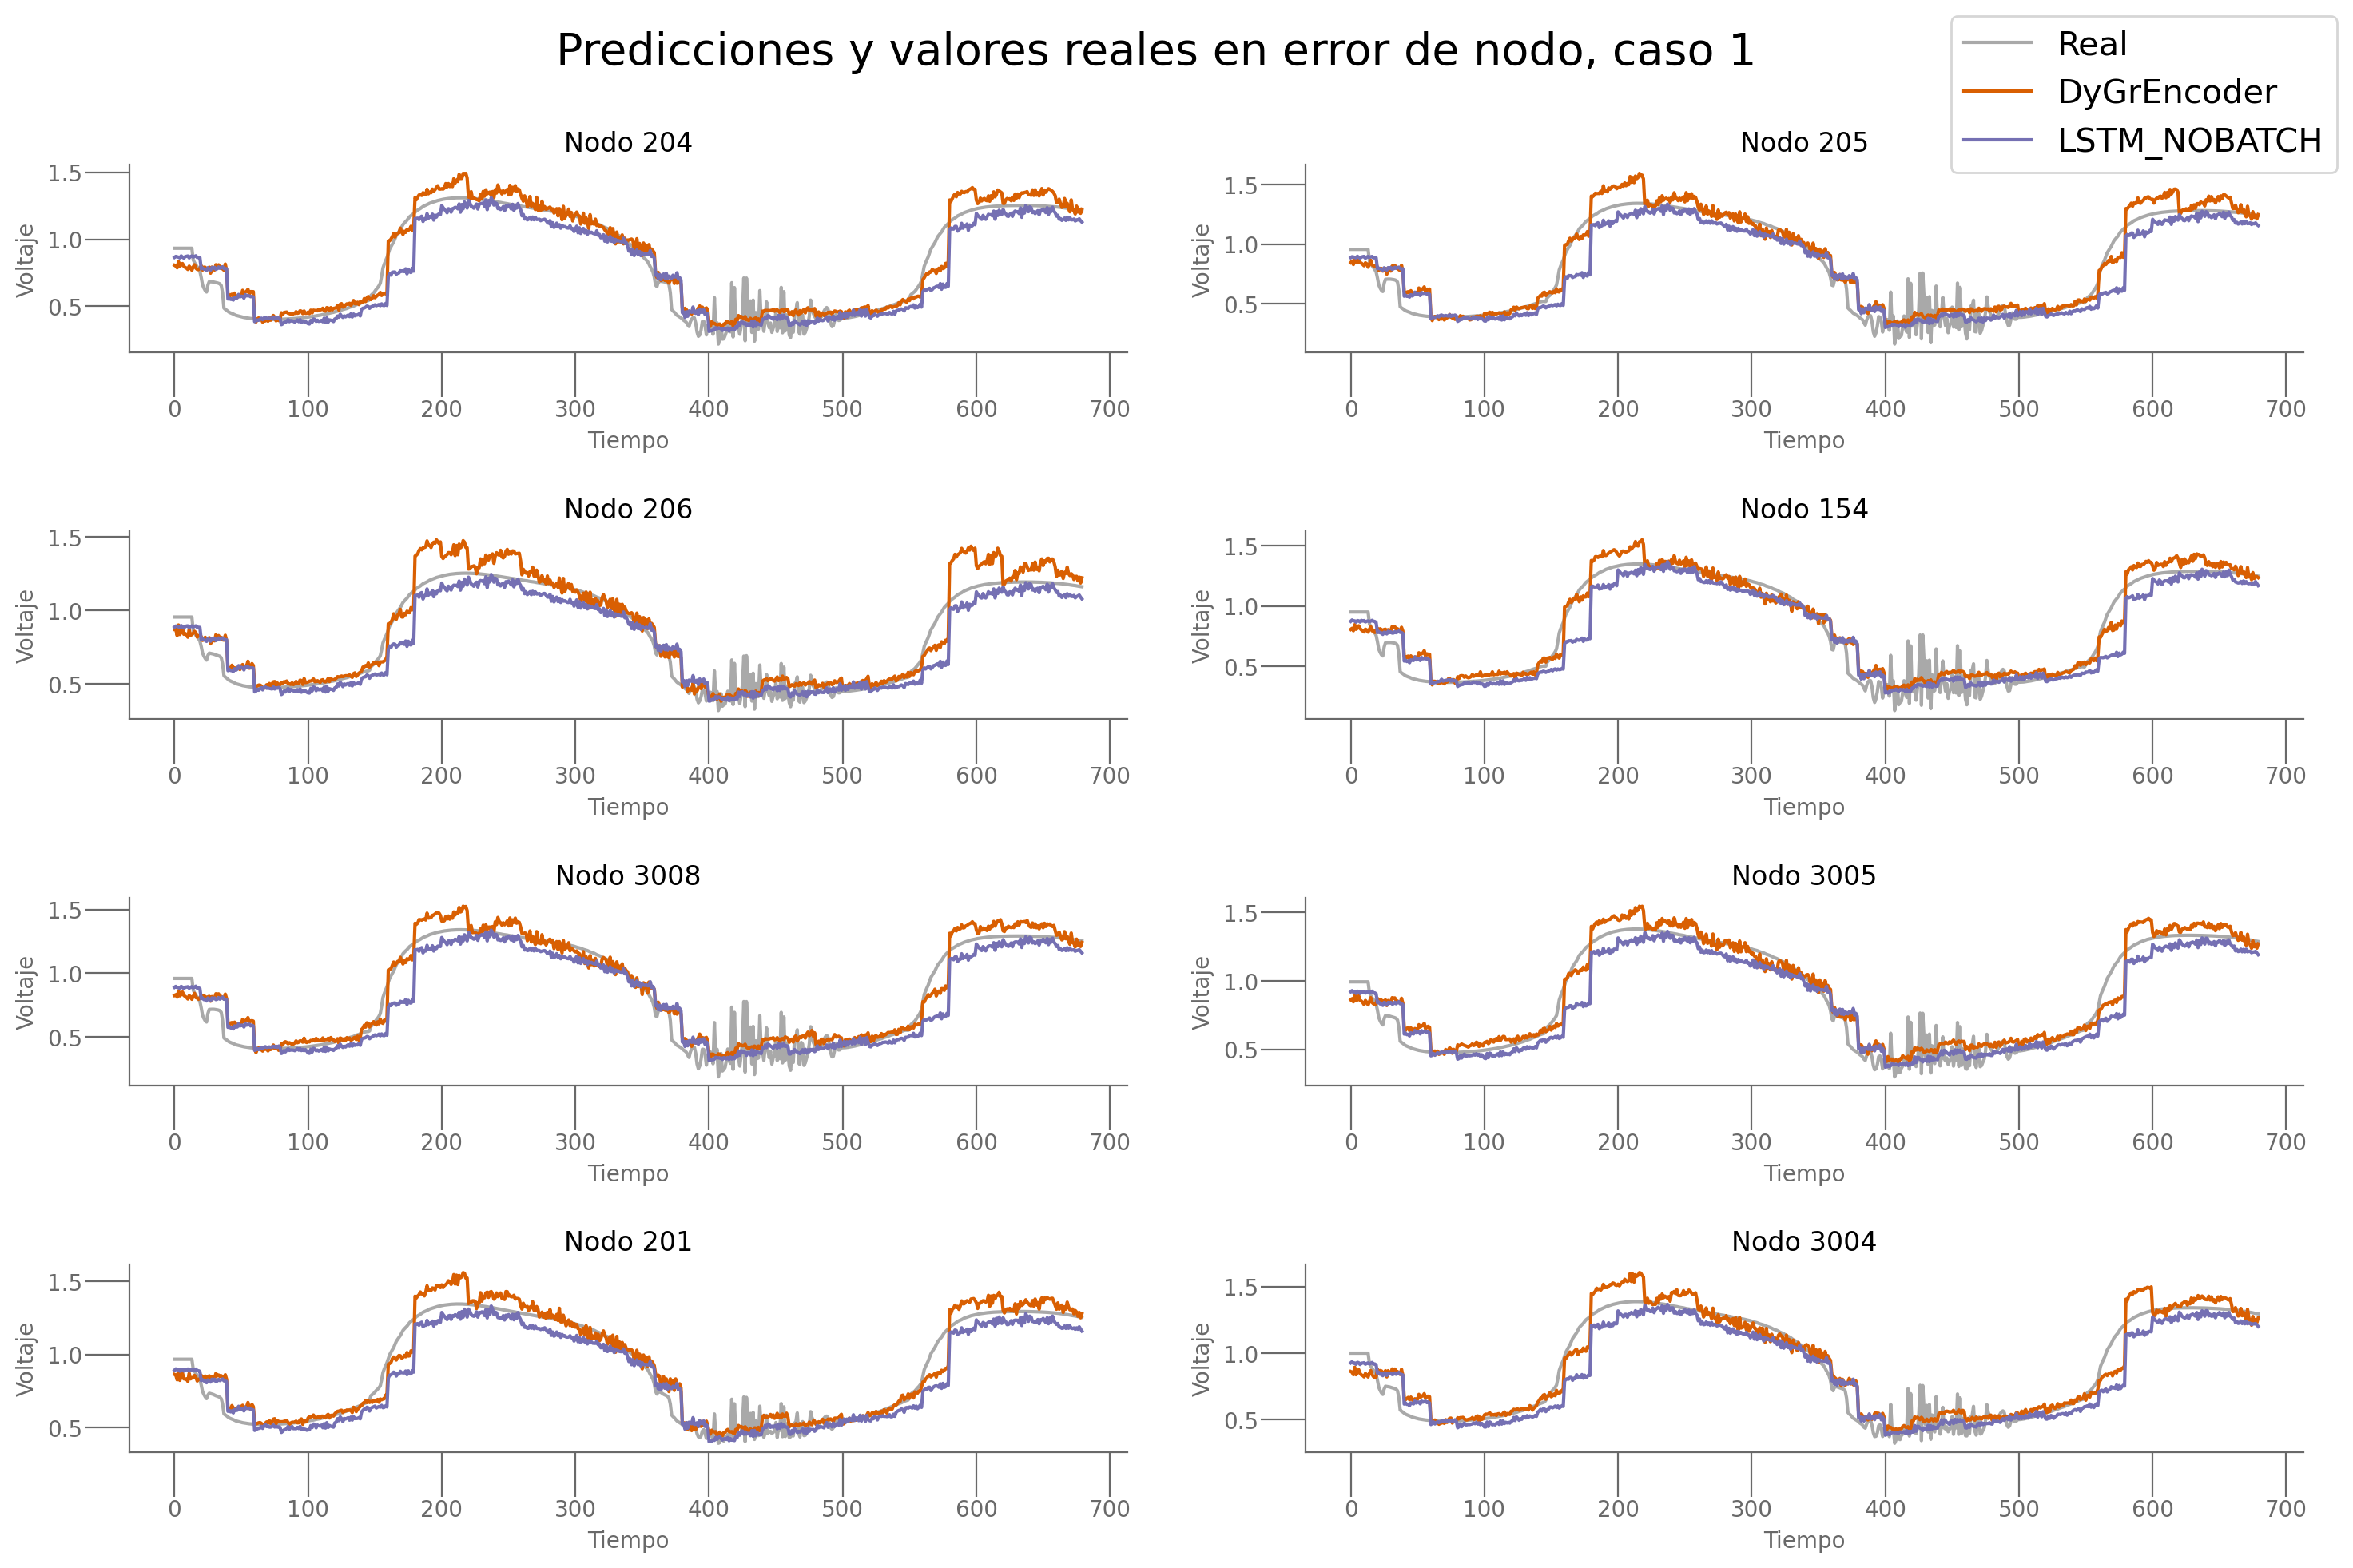

[8, 9, 5, 7, 2, 22, 19, 15]


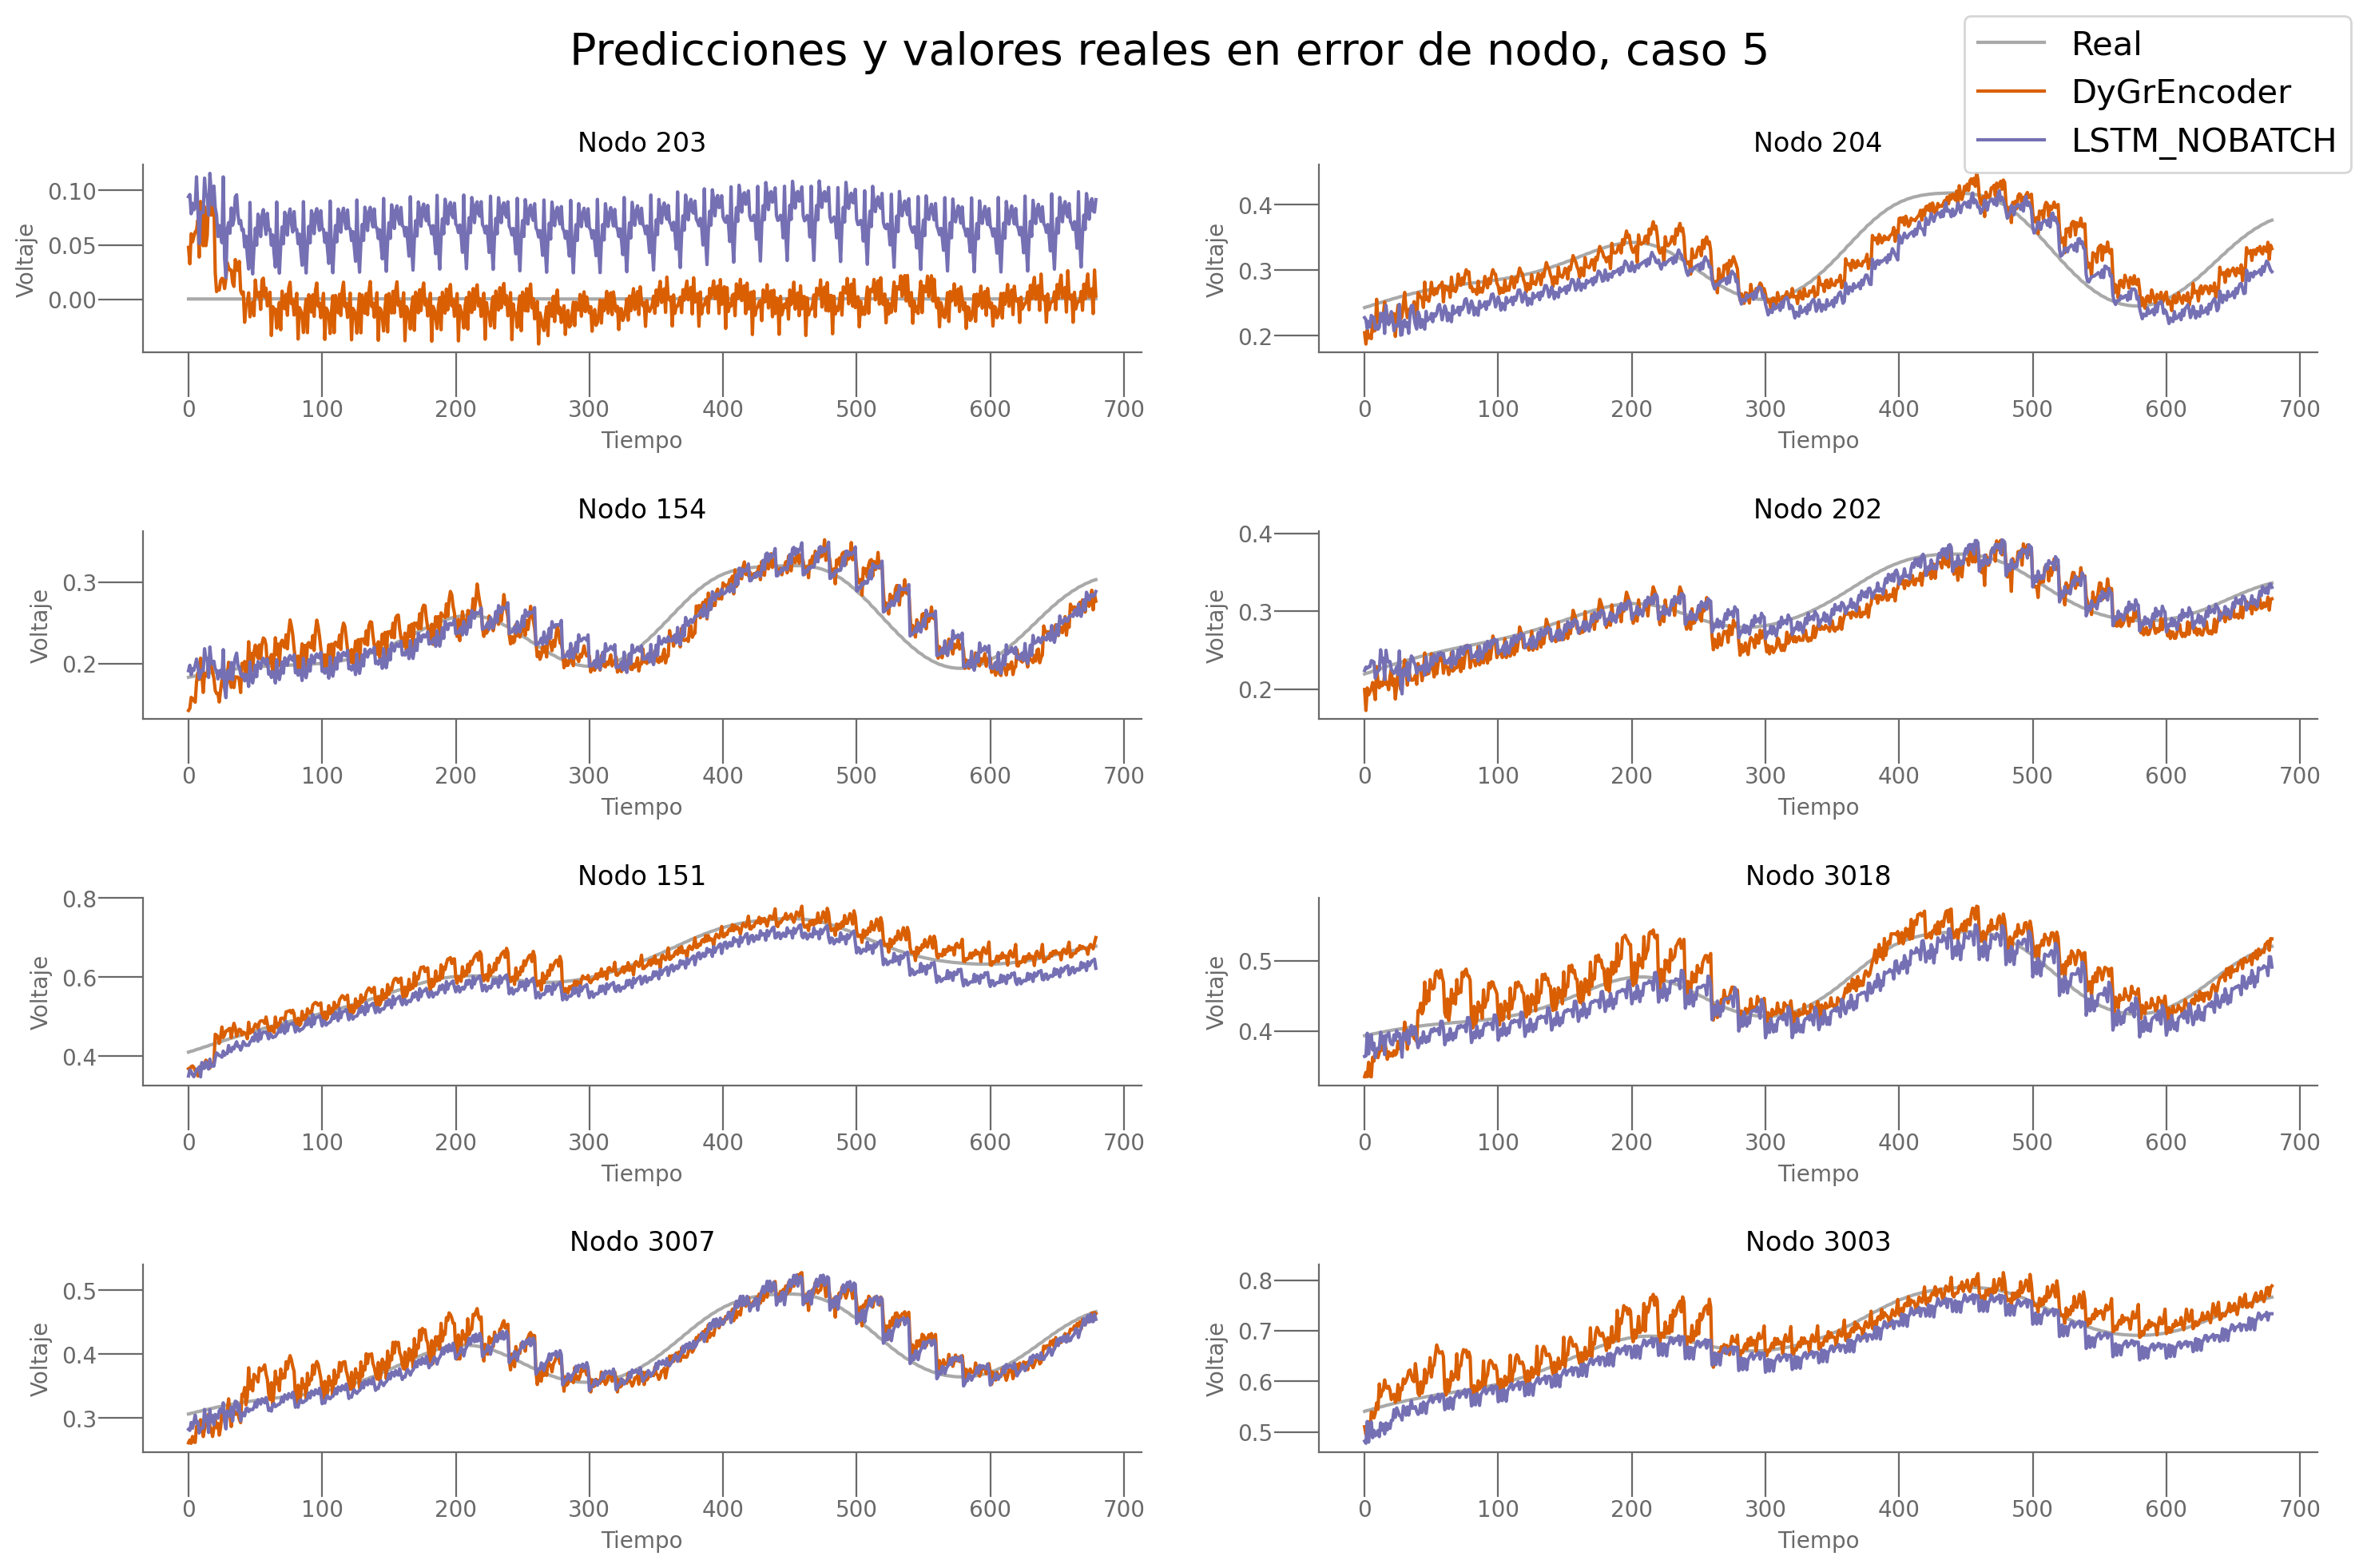

Procesando modelo:  MSTGCN


Modelo:  MSTGCN
{'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 50}

==================== TEST INFO ===================

test loss: 0.019044, test R2 score: -0.908945


Modelo:  ASTGCN
{'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 50}
path:  ../experimentos_split/results/bus_fault/ASTGCN.pt

==================== TEST INFO ===================

test loss: 0.017888, test R2 score: -0.668460


Modelo:  LSTM_NOBATCH
{}

==================== TEST INFO ===================

test loss: 0.017863, test R2 score: -1.113234
[9, 10, 11, 5, 15, 3, 12, 8]


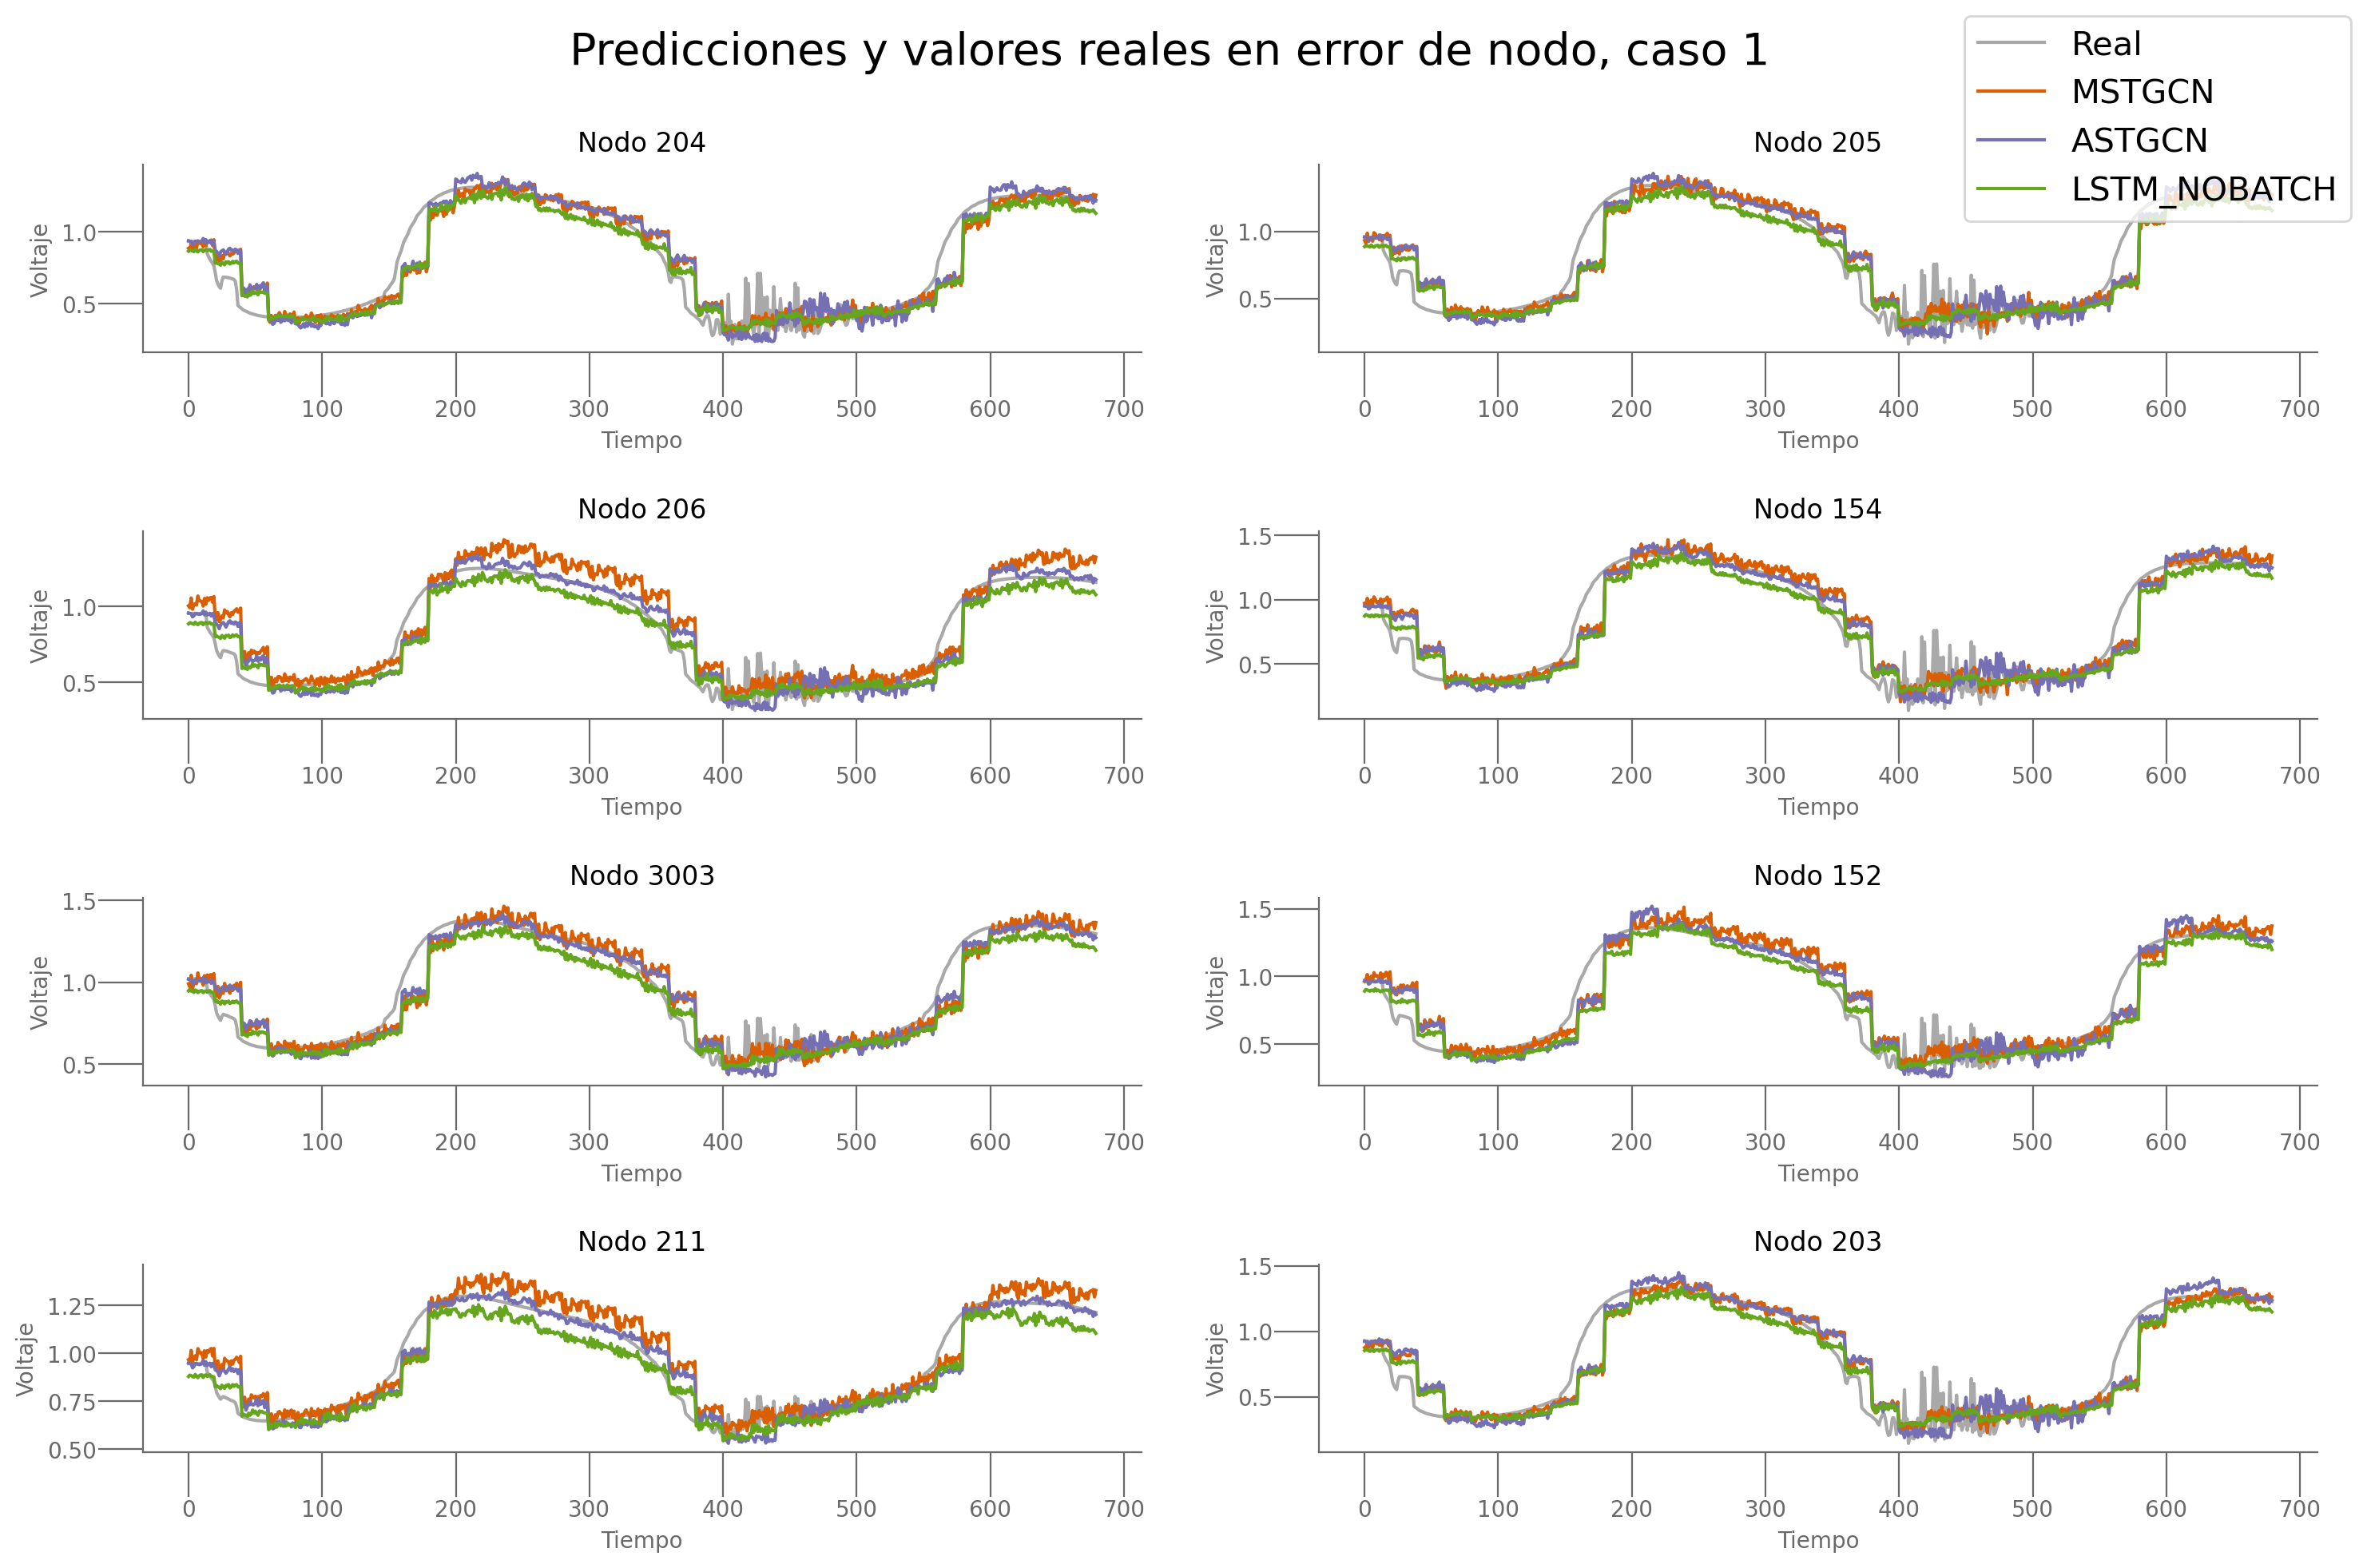

[8, 9, 5, 7, 10, 14, 17, 16]


Procesando modelo:  MPNN_LSTM


Modelo:  MPNN_LSTM
{'hidden_size': 64, 'dropout': 0.2}

==================== TEST INFO ===================



ValueError: Input contains NaN.

In [22]:
models_2 = ["DyGrEncoder", "MSTGCN", "MPNN_LSTM", "DCRNN", "MTGNN", "EvolveGCN"]
print("Problema: ", problem)
p_es = "error de nodo"
path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"
for m in models_2:
    print("Procesando modelo: ", m)
    models_analysis = [ m,"LSTM_NOBATCH"] if m != "MSTGCN" else [m, "ASTGCN", "LSTM_NOBATCH"]
    predictions = {}
    real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
    for model_name in models_analysis:
        print("\n\nModelo: ", model_name)
        trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
        _,_,_,preds, reals = trainer.test()
        predictions[model_name] = preds
        real[model_name] = reals

    from importlib import reload

    utils_graph =reload(utils.utils_graph)
    from utils.utils_graph import plot_predictions, plot_multiple_models
    

    predictions_list= [value for value in predictions.values()]
    real_list = [value for value in real.values()]
    num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=1, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_1.png")
    plt.show()

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=5, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_5.png")
    plt.show()

### Modelo único

In [14]:
model_name = "MPNN_LSTM" #MPNN_LSTM, AGCRN, LSTM, DyGrEncoder
trainer = trainer = process_model(model_name, path_problem_results, dataset, dataloader_params)
_,_,_,preds, reals = trainer.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.045889, test r2score -18.247558


In [15]:
plot_predictions(preds,reals,  n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=problem)

### Tablas de resultados

In [ ]:
problem = "gen_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/gen_trip


In [19]:
df = pd.read_csv(path_problem_results+'/results.csv')
df.sort_values(by='Loss_tst')

Modelo                                 Params  \
3   DyGrEncoder  {'aggr': 'add', 'conv': 1, 'lstm': 1}   
2  LSTM_NOBATCH                                    NaN   
0          LSTM                                    NaN   
4         AGCRN                  {'hidden': 5, 'K': 2}   
1     MPNN_LSTM    {'hidden_size': 16, 'dropout': 0.2}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.204836   
2                                                NaN  0.007437  -1.985579   
0                                                NaN  0.007638   0.204209   
4       ./results/gen_trip/ajustes/AGCRN_results.csv  0.008500   0.207796   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   

                                          Loss_nodes    R2_eval  Loss_eval  \
3  [[0.00222953 0.00414274 0.00527185 0.00363695 ...  -1.286139   0.008926   
2  [0.00509721 0.00360723 0.00449464 0.00795687 0...  -1.845531   0.009937   
0  [0.00403222 0.0036478  0.00494586 0.00812658 0...   0.341164   0.009765   
4  [0.00447821 0.00441905 0.00496255 0.00878396 0...   0.243349   0.011286   
1  [0.04005108401179314, 0.03960233926773071, 0.0... -16.743964   0.052820   

   Loss_final  
3    0.006838  
2    0.009110  
0    0.008689  
4    0.009918  
1    0.059339